In [44]:
import openseespy.opensees as ops
import numpy as np
import opsvis as ovs
import matplotlib.pyplot as plt

In [45]:
#data in SI
gap = 0.03

m1 = 75*10**3
m2 = 3000*10**3

T1 = 1.2
T2 = 0.3

c1 = 39270
c2 = 6.283*10**6

k1 = 2.056*10**6
k2 = 1.316*10**9

In [46]:

## define DAMPING--------------------------------------------------------------------------------------
## apply Rayleigh DAMPING from $xDamp
## D=$alphaM*M + $betaKcurr*Kcurrent + $betaKcomm*KlastCommit + $beatKinit*$Kinitial
def setDamping():
    xDamp= 0.02				# 2% damping ratio
    lambda_ =  ops.eigen(1)[0]			# eigenvalue mode 1
    omega = pow(lambda_,0.5)
    alphaM =  0.				# M-prop. damping; D = alphaM*M
    betaKcurr =  0.         			# K-proportional damping;      +beatKcurr*KCurrent
    betaKcomm =  2.*xDamp/omega  	# K-prop. damping parameter;   +betaKcomm*KlastCommitt
    betaKinit =  0.		# initial-stiffness proportional damping      +beatKinit*Kini
    # define damping
    ops.rayleigh(alphaM, betaKcurr, betaKinit, betaKcomm) # RAYLEIGH damping



In [135]:
ops.wipe()
ops.model('BasicBuilder', '-ndm', 1, '-ndf', 1)


ops.node(1, 0)
ops.node(2, 0)


gap = 0.03 #0.03m = 30mm
ops.node(3, gap)
ops.node(4, gap)

ops.fix(1, 1)
ops.fix(3, 1)

ops.mass(2, 75.0e3)
ops.mass(4, 3000.0e3)


#uniaxialMaterial('Elastic', matTag, E, eta=0.0, Eneg=E)
#LEFT SDOF SYSTEM
ops.uniaxialMaterial('Elastic', 101, k1) #left stiffness param
ops.uniaxialMaterial('Viscous', 201, c1, 1) #left damping param
ops.uniaxialMaterial('Parallel', 301, *[101, 201]) #left combined
ops.element('zeroLength', 101, *[1,2], '-mat', 301, '-dir', 1) #element


# RIGHT SDOF SYSTEM
ops.uniaxialMaterial('Elastic', 102, k2) #right
ops.uniaxialMaterial('Viscous', 202, c2, 1) #right
ops.uniaxialMaterial('Parallel', 302, *[201, 202]) #right combined
ops.element('zeroLength', 102, *[4,3], '-mat', 302,'-dir', 1) #element


#for kelvin voigt material
k =  93500e3
c = 520e3
kg = k2
ops.uniaxialMaterial('Elastic', 103, k) #kelvin voigt
ops.uniaxialMaterial('Viscous', 203, c, 1)
ops.uniaxialMaterial('Parallel', 303, *[103, 203])
# uniaxialMaterial ElasticPPGap $matTag $E $Fy $gap $eta <damage>
ops.uniaxialMaterial('ElasticPPGap', 403, kg, -250e6, -1*gap, 0.1)
ops.uniaxialMaterial('Series', 503, *[303, 403])


#add kelvin voigt element
ops.node(5, 0)
ops.element('zeroLength', 103, *[2,5], '-mat', 303, '-dir', 1)
#ops.equalDOF(2,5,*[2,3])
ops.element('twoNodeLink', 104, *[5, 4], '-mat', 403, '-dir', 1)

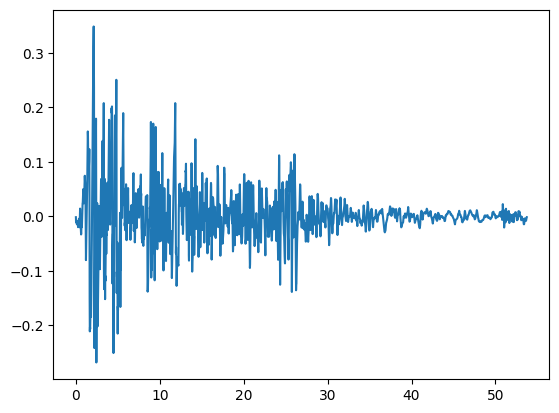

In [136]:
eqDataElCentro = np.loadtxt('data/elcentro.txt')
time = eqDataElCentro[:, 0]
accel = eqDataElCentro[:, 1]
plt.plot(time, accel)

In [137]:
DtAnalysis = 0.005 #for analysis
TmaxAnalysis = 10 #for analysis
Nstep = int(TmaxAnalysis/DtAnalysis)

GM_dirn = 1
GM_fact = 1.0*9.81
gmTS = 1
dt = 0.01		# time step for input ground motion

#for elcentro
#ops.timeSeries("Path", gmTS, '-time', *time, '-values', *accel)

# for others
ops.timeSeries("Path", gmTS, '-time', *time, '-values', *accel)

#pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
ops.pattern('UniformExcitation', 1, GM_dirn, '-accel', gmTS, '-factor', GM_fact)


######## RECORDERS #########
ops.recorder('Node', '-file', 'left_corner.txt', '-time', '-closeOnWrite','-node',2 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'KVmidnode_disp.txt', '-time', '-closeOnWrite','-node',5 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'right_corner.txt', '-time', '-closeOnWrite','-node',4 , '-dof', 1, 'disp')

ops.recorder('Node', '-file', 'left_corner_vel.txt', '-time', '-closeOnWrite','-node',2 , '-dof', 1, 'vel')
ops.recorder('Node', '-file', 'KVmidnode_vel.txt', '-time', '-closeOnWrite','-node',5 , '-dof', 1, 'vel')
ops.recorder('Node', '-file', 'right_corner_vel.txt', '-time', '-closeOnWrite','-node',4 , '-dof', 1, 'vel')


#ops.recorder('Element', '-file', 'eppDisplacement.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'deformation')
ops.recorder('Element', '-file', 'Reactions_EPP.txt', '-time', '-closeOnWrite','-ele',103 , '-dof', 1, 'force')
ops.recorder('Element', '-file', 'Reactions_KV.txt', '-time', '-closeOnWrite','-ele',104 , '-dof', 1, 'force')


ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("ProfileSPD")
tol = 1.e-8
maxNumIter = 50
ops.test("EnergyIncr", tol, maxNumIter)
ops.algorithm("ModifiedNewton")
ops.integrator("Newmark", .5, .25)
ops.analysis("Transient")

for i in range(Nstep):
    status = ops.analyze(1, DtAnalysis)
    # ovs.plot_defo()
    # plt.savefig(f'test_images/{(i+1)*DtAnalysis}s_{TmaxAnalysis}.png')
    # plt.close()
    print(f"Ground Motion - {i+1}/{Nstep}")
    if status != 0:
        print("Analysis failed trying Krylov Newton...")
        ops.algorithm('KrylovNewton')
        status = ops.analyze(1, DtAnalysis)
    if status != 0:
        print("Analysis failed trying with more iterations and less tolerance...")
        tol = 1.e-6
        maxNumIter = 100
        ops.system("BandSPD")
        ops.test("RelativeNormDispIncr", tol, maxNumIter)
        status = ops.analyze(1, DtAnalysis)
    if status!=0:
        print("Analysis failed trying Bryoden Algorithm")
        tol = 1.e-8
        maxNumIter = 50
        ops.test("EnergyIncr", tol, maxNumIter)
        ops.algorithm('Broyden')
        status = ops.integrator("HHT", 0.85, .5, .25)
        status = ops.analyze(1, DtAnalysis)
        #
    if status != 0:
        print("Breaking analysis")
        break
    
    ops.algorithm('ModifiedNewton')
    ops.system("ProfileSPD")
    tol = 1.e-10
    maxNumIter = 50    
    ops.test("EnergyIncr", tol, maxNumIter)
 

Ground Motion - 1/2000
Ground Motion - 2/2000
Ground Motion - 3/2000
Ground Motion - 4/2000
Ground Motion - 5/2000
Ground Motion - 6/2000
Ground Motion - 7/2000
Ground Motion - 8/2000
Ground Motion - 9/2000
Ground Motion - 10/2000
Ground Motion - 11/2000
Ground Motion - 12/2000
Ground Motion - 13/2000
Ground Motion - 14/2000
Ground Motion - 15/2000
Ground Motion - 16/2000
Ground Motion - 17/2000
Ground Motion - 18/2000
Ground Motion - 19/2000
Ground Motion - 20/2000
Ground Motion - 21/2000
Ground Motion - 22/2000
Ground Motion - 23/2000
Ground Motion - 24/2000
Ground Motion - 25/2000
Ground Motion - 26/2000
Ground Motion - 27/2000
Ground Motion - 28/2000
Ground Motion - 29/2000
Ground Motion - 30/2000
Ground Motion - 31/2000
Ground Motion - 32/2000
Ground Motion - 33/2000
Ground Motion - 34/2000
Ground Motion - 35/2000
Ground Motion - 36/2000
Ground Motion - 37/2000
Ground Motion - 38/2000
Ground Motion - 39/2000
Ground Motion - 40/2000
Ground Motion - 41/2000
Ground Motion - 42/2000
G

after: 50 iterations
 current EnergyIncr: 704.282 (max: 1e-10) 	Norm deltaX: 0.00218838, Norm deltaR: 909984
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.72
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 2.37621e-10 (max: 1e-10) 	Norm deltaX: 6.00752e-10, Norm deltaR: 1.11841
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 1.81
OpenSees > analyze failed, returned: -3 error flag


Ground Motion - 417/2000
Ground Motion - 418/2000
Ground Motion - 419/2000
Ground Motion - 420/2000
Ground Motion - 421/2000
Ground Motion - 422/2000
Ground Motion - 423/2000
Ground Motion - 424/2000
Ground Motion - 425/2000
Ground Motion - 426/2000
Ground Motion - 427/2000
Ground Motion - 428/2000
Ground Motion - 429/2000
Ground Motion - 430/2000
Ground Motion - 431/2000
Ground Motion - 432/2000
Ground Motion - 433/2000
Ground Motion - 434/2000
Ground Motion - 435/2000
Ground Motion - 436/2000
Ground Motion - 437/2000
Ground Motion - 438/2000
Ground Motion - 439/2000
Ground Motion - 440/2000
Ground Motion - 441/2000
Ground Motion - 442/2000
Ground Motion - 443/2000
Ground Motion - 444/2000
Ground Motion - 445/2000
Ground Motion - 446/2000
Ground Motion - 447/2000
Ground Motion - 448/2000
Ground Motion - 449/2000
Ground Motion - 450/2000
Ground Motion - 451/2000
Ground Motion - 452/2000
Ground Motion - 453/2000
Ground Motion - 454/2000
Ground Motion - 455/2000
Ground Motion - 456/2000


after: 50 iterations
 current EnergyIncr: 2198.77 (max: 1e-10) 	Norm deltaX: 0.00386669, Norm deltaR: 1.60787e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.45
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 1.03732e-09 (max: 1e-10) 	Norm deltaX: 1.25519e-09, Norm deltaR: 2.33677
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.545
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 1009.36 (max: 1e-10) 	Norm deltaX: 0.00261983, Norm deltaR: 1.08939e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.76
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 1.

Ground Motion - 534/2000
Ground Motion - 535/2000
Ground Motion - 536/2000
Ground Motion - 537/2000
Ground Motion - 538/2000
Ground Motion - 539/2000
Ground Motion - 540/2000
Ground Motion - 541/2000
Ground Motion - 542/2000
Ground Motion - 543/2000
Ground Motion - 544/2000
Ground Motion - 545/2000
Ground Motion - 546/2000
Ground Motion - 547/2000
Ground Motion - 548/2000
Ground Motion - 549/2000
Ground Motion - 550/2000
Ground Motion - 551/2000
Ground Motion - 552/2000
Analysis failed trying Krylov Newton...
Ground Motion - 553/2000
Ground Motion - 554/2000
Ground Motion - 555/2000
Ground Motion - 556/2000
Ground Motion - 557/2000
Ground Motion - 558/2000
Ground Motion - 559/2000
Ground Motion - 560/2000
Ground Motion - 561/2000
Ground Motion - 562/2000
Ground Motion - 563/2000
Ground Motion - 564/2000
Ground Motion - 565/2000
Ground Motion - 566/2000
Ground Motion - 567/2000
Ground Motion - 568/2000
Ground Motion - 569/2000
Ground Motion - 570/2000
Analysis failed trying Krylov Newto

after: 50 iterations
 current EnergyIncr: 3339.09 (max: 1e-10) 	Norm deltaX: 0.00476501, Norm deltaR: 1.98141e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.67
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 3.70816e-10 (max: 1e-10) 	Norm deltaX: 7.50467e-10, Norm deltaR: 1.39713
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.755
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 4522.52 (max: 1e-10) 	Norm deltaX: 0.00554549, Norm deltaR: 2.30596e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.17
OpenSees > analyze failed, returned: -3 error flag


Ground Motion - 1056/2000
Ground Motion - 1057/2000
Ground Motion - 1058/2000
Ground Motion - 1059/2000
Ground Motion - 1060/2000
Ground Motion - 1061/2000
Ground Motion - 1062/2000
Ground Motion - 1063/2000
Ground Motion - 1064/2000
Ground Motion - 1065/2000
Ground Motion - 1066/2000
Ground Motion - 1067/2000
Ground Motion - 1068/2000
Ground Motion - 1069/2000
Ground Motion - 1070/2000
Ground Motion - 1071/2000
Ground Motion - 1072/2000
Ground Motion - 1073/2000
Ground Motion - 1074/2000
Ground Motion - 1075/2000
Ground Motion - 1076/2000
Ground Motion - 1077/2000
Ground Motion - 1078/2000
Ground Motion - 1079/2000
Ground Motion - 1080/2000
Ground Motion - 1081/2000
Ground Motion - 1082/2000
Ground Motion - 1083/2000
Ground Motion - 1084/2000
Ground Motion - 1085/2000
Ground Motion - 1086/2000
Ground Motion - 1087/2000
Ground Motion - 1088/2000
Ground Motion - 1089/2000
Ground Motion - 1090/2000
Ground Motion - 1091/2000
Ground Motion - 1092/2000
Ground Motion - 1093/2000
Ground Motio

after: 50 iterations
 current EnergyIncr: 7.20386 (max: 1e-10) 	Norm deltaX: 0.000221326, Norm deltaR: 92033
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 6.465
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 1.26028e-10 (max: 1e-10) 	Norm deltaX: 4.37508e-10, Norm deltaR: 0.814501
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 6.54
OpenSees > analyze failed, returned: -3 error flag


Ground Motion - 1300/2000
Ground Motion - 1301/2000
Ground Motion - 1302/2000
Ground Motion - 1303/2000
Ground Motion - 1304/2000
Ground Motion - 1305/2000
Ground Motion - 1306/2000
Ground Motion - 1307/2000
Ground Motion - 1308/2000
Analysis failed trying Krylov Newton...
Ground Motion - 1309/2000
Ground Motion - 1310/2000
Ground Motion - 1311/2000
Ground Motion - 1312/2000
Ground Motion - 1313/2000
Ground Motion - 1314/2000
Ground Motion - 1315/2000
Ground Motion - 1316/2000
Ground Motion - 1317/2000
Ground Motion - 1318/2000
Ground Motion - 1319/2000
Ground Motion - 1320/2000
Ground Motion - 1321/2000
Ground Motion - 1322/2000
Ground Motion - 1323/2000
Ground Motion - 1324/2000
Ground Motion - 1325/2000
Ground Motion - 1326/2000
Ground Motion - 1327/2000
Ground Motion - 1328/2000
Ground Motion - 1329/2000
Ground Motion - 1330/2000
Ground Motion - 1331/2000
Ground Motion - 1332/2000
Ground Motion - 1333/2000
Ground Motion - 1334/2000
Ground Motion - 1335/2000
Ground Motion - 1336/200

after: 50 iterations
 current EnergyIncr: 204.682 (max: 1e-10) 	Norm deltaX: 0.00117975, Norm deltaR: 490570
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 7.505
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 3.65487e-10 (max: 1e-10) 	Norm deltaX: 7.45055e-10, Norm deltaR: 1.38706
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 7.58
OpenSees > analyze failed, returned: -3 error flag


Ground Motion - 1559/2000
Ground Motion - 1560/2000
Ground Motion - 1561/2000
Ground Motion - 1562/2000
Ground Motion - 1563/2000
Ground Motion - 1564/2000
Ground Motion - 1565/2000
Ground Motion - 1566/2000
Ground Motion - 1567/2000
Ground Motion - 1568/2000
Ground Motion - 1569/2000
Ground Motion - 1570/2000
Ground Motion - 1571/2000
Ground Motion - 1572/2000
Ground Motion - 1573/2000
Ground Motion - 1574/2000
Ground Motion - 1575/2000
Ground Motion - 1576/2000
Ground Motion - 1577/2000
Ground Motion - 1578/2000
Ground Motion - 1579/2000
Ground Motion - 1580/2000
Ground Motion - 1581/2000
Ground Motion - 1582/2000
Ground Motion - 1583/2000
Ground Motion - 1584/2000
Ground Motion - 1585/2000
Ground Motion - 1586/2000
Ground Motion - 1587/2000
Ground Motion - 1588/2000
Ground Motion - 1589/2000
Ground Motion - 1590/2000
Ground Motion - 1591/2000
Ground Motion - 1592/2000
Ground Motion - 1593/2000
Ground Motion - 1594/2000
Ground Motion - 1595/2000
Ground Motion - 1596/2000
Ground Motio

after: 50 iterations
 current EnergyIncr: 478.044 (max: 1e-10) 	Norm deltaX: 0.00180295, Norm deltaR: 749713
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 8.2
OpenSees > analyze failed, returned: -3 error flag


Ground Motion - 1670/2000
Ground Motion - 1671/2000
Ground Motion - 1672/2000
Ground Motion - 1673/2000
Ground Motion - 1674/2000
Ground Motion - 1675/2000
Ground Motion - 1676/2000
Ground Motion - 1677/2000
Ground Motion - 1678/2000
Ground Motion - 1679/2000
Ground Motion - 1680/2000
Ground Motion - 1681/2000
Ground Motion - 1682/2000
Ground Motion - 1683/2000
Ground Motion - 1684/2000
Ground Motion - 1685/2000
Ground Motion - 1686/2000
Ground Motion - 1687/2000
Ground Motion - 1688/2000
Ground Motion - 1689/2000
Ground Motion - 1690/2000
Ground Motion - 1691/2000
Ground Motion - 1692/2000
Ground Motion - 1693/2000
Ground Motion - 1694/2000
Ground Motion - 1695/2000
Ground Motion - 1696/2000
Ground Motion - 1697/2000
Ground Motion - 1698/2000
Ground Motion - 1699/2000
Ground Motion - 1700/2000
Ground Motion - 1701/2000
Ground Motion - 1702/2000
Ground Motion - 1703/2000
Ground Motion - 1704/2000
Ground Motion - 1705/2000
Ground Motion - 1706/2000
Ground Motion - 1707/2000
Ground Motio

(-0.2, 0.1)

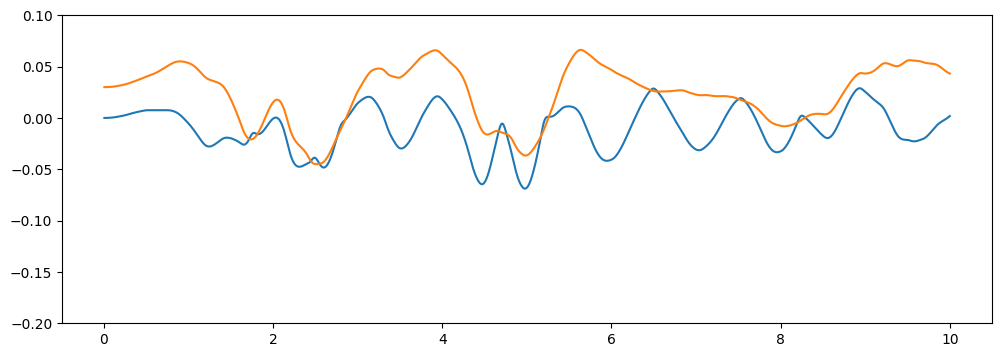

In [138]:
left_node_disp=np.loadtxt('left_corner.txt',delimiter = " ")
right_node_disp=np.loadtxt('right_corner.txt',delimiter = " ")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(left_node_disp[:,0],left_node_disp[:,1])
ax.plot(right_node_disp[:,0],right_node_disp[:, 1]+gap)
ax.set_ylim((-0.2, 0.1))

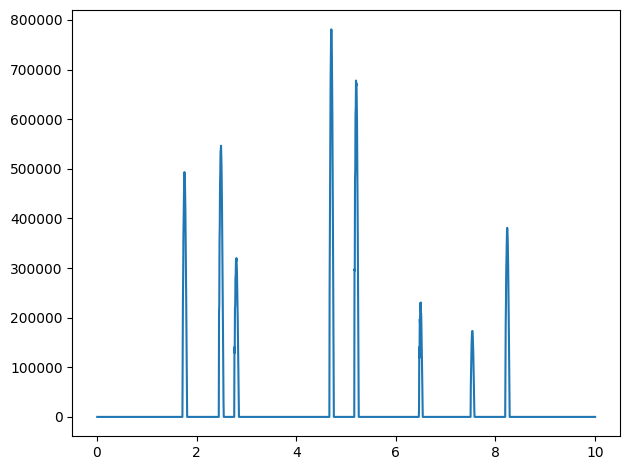

In [139]:
forceEPP=np.loadtxt('Reactions_EPP.txt',delimiter = " ")
forceKelvinVoigt=np.loadtxt('Reactions_KV.txt',delimiter = " ")

fig,axis = plt.subplots()
axis.plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])
#axis[0].plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])
#axis[0].plot(forceEPP[:,0],forceEPP[:,1])
#plt.xlim([1.3,1.4])
plt.tight_layout()

Text(0.5, 1.0, 'zooming into a impact force')

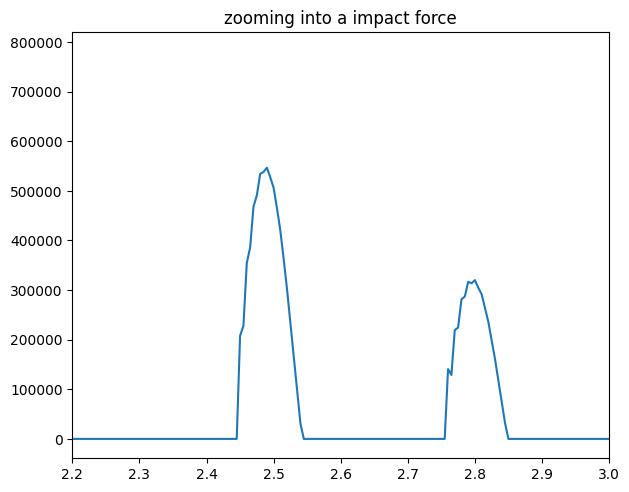

In [140]:
fig,axis = plt.subplots()
axis.plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])
#axis[0].plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])
#axis[0].plot(forceEPP[:,0],forceEPP[:,1])
plt.xlim([2.2,3])
plt.tight_layout()
plt.title("zooming into a impact force")

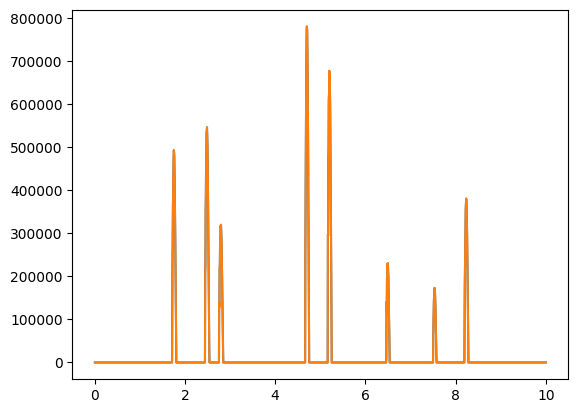

In [141]:
kvmidnode_disp = np.loadtxt('KVmidnode_disp.txt', delimiter = " ")
kvmidnode_vel = np.loadtxt('KVmidnode_vel.txt', delimiter = " ")
left_node_vel=np.loadtxt('left_corner_vel.txt',delimiter = " ")
right_node_vel=np.loadtxt('right_corner_vel.txt',delimiter = " ")

time = left_node_vel[:,0]

#print(right_node_vel)
# left_node_disp, right_node_disp
force = np.zeros_like(left_node_disp[:, 1])
force = k * (left_node_disp[:,1] - kvmidnode_disp[:,1]) + c *(left_node_vel[:,1] - kvmidnode_vel[:,1])
collision = left_node_disp[:,1] - right_node_disp[:,1] - gap
iscollided = collision >= 0
#force[~iscollided] = 0


force_EPP = kg*(kvmidnode_disp[:,1] - right_node_disp[:,1]- gap)
force_EPP[~iscollided] = 0

#print(len(time), len(force))
plt.plot(time, force)
plt.plot(forceKelvinVoigt[:,0],forceKelvinVoigt[:,1])


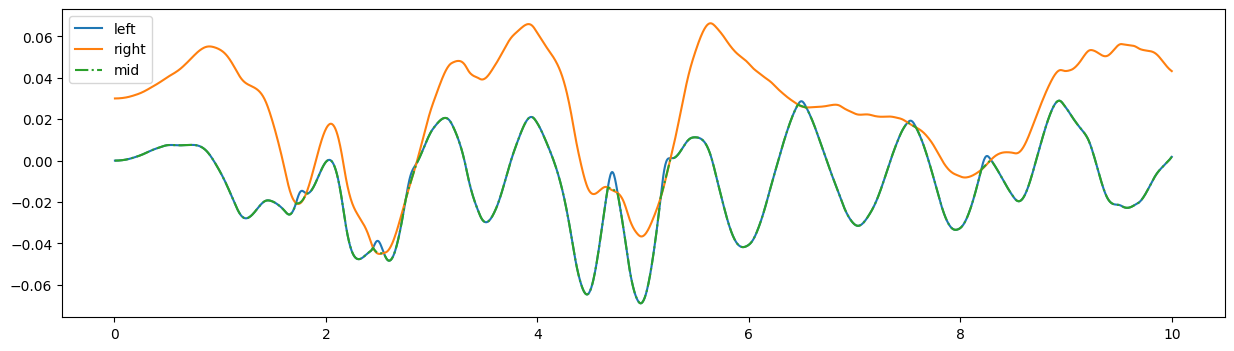

In [142]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(time, left_node_disp[:, 1], label='left')
plt.plot(time, right_node_disp[:, 1]+gap, label='right')
plt.plot(time, kvmidnode_disp[:, 1],'-.', label='mid')
plt.legend()


(2.5, 2.7)

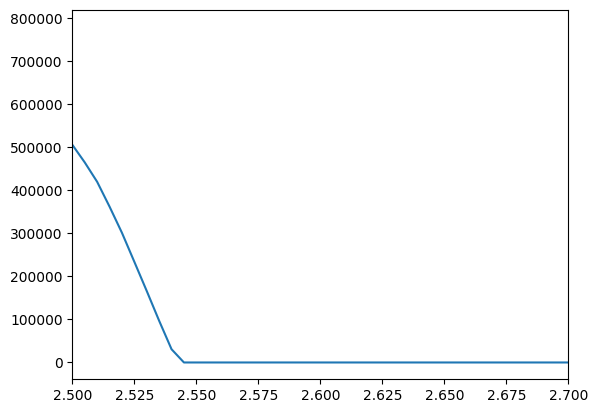

In [143]:
plt.plot(time, force)
plt.xlim([2.5,2.7])

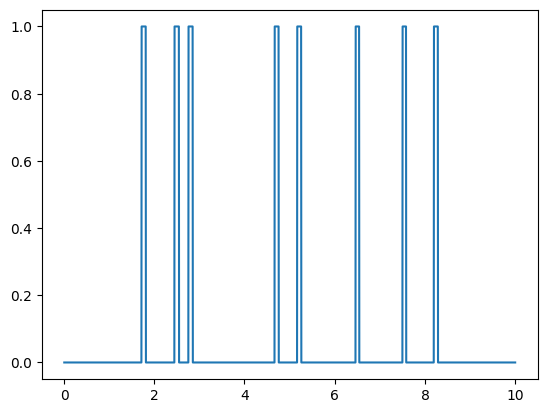

In [144]:
plt.plot(forceKelvinVoigt[:,0], iscollided)

In [146]:
for i in range (len(force)):
    print(forceKelvinVoigt[:,1][i], force[i],force_EPP[i], forceEPP[i,1])

0.0 0.0 0.0 -1.90445e-14
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 -1.12757e-13
0.0 0.0 0.0 -3.38271e-13
0.0 0.0 0.0 -1.31012e-12
0.0 0.0 0.0 -4.08067e-13
0.0 0.0 0.0 -8.59095e-13
0.0 0.0 0.0 -1.9437e-12
0.0 0.0 0.0 -1.26716e-12
0.0 0.0 0.0 0.0
0.0 0.0 0.0 -3.43638e-12
0.0 0.0 0.0 -1.63227e-12
0.0 0.0 0.0 -1.63227e-12
0.0 0.0 0.0 -1.63227e-12
0.0 0.0 0.0 9.02056e-13
0.0 0.0 0.0 -2.70617e-12
0.0 0.0 0.0 0.0
0.0 0.0 0.0 -1.80411e-12
0.0 0.0 0.0 -6.87276e-12
0.0 0.0 0.0 -1.46042e-12
0.0 0.0 0.0 -1.01373e-11
0.0 0.0 0.0 -4.72495e-12
0.0 0.0 0.0 5.41234e-12
0.0 0.0 0.0 -3.60822e-12
0.0 0.0 0.0 0.0
0.0 0.0 0.0 -3.60822e-12
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0
0.0 0.0 0.0 -3.60822e-12
0.0 0.0 0.0 -1.80411e-12
0.0 0.0 0.0 0.0
0.0 0.0 0.0 -3.60822e-12
0.0 0.0 0.0 -1.80411e-12
0.0 0.0 0.0 1.80411e-12
0.0 0.0 0.0 -1.80411e-12
0.0 0.0 0.0 -1.80411e-12
0.0 0.0 0.0 1.80411e-12
0.0 0.0 0.0 -1.80411e-12
0.0 0.0 0.0 -2.20787e-11
0.0 0.0 0.0 -1.1254e-11
0.0 0.0 0.0 -3.15286e-11
0.0 0.0 0.0 